# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan

# Exercise 1: Rocket Data

In [2]:
rockets = pd.read_csv("data/failure_counts.csv")
rockets

,LV.Type,numberOfLaunches,numberOfFailures
0,Aerobee,1,0
1,Angara A5,1,0
2,Antares 110,2,0
3,Antares 120,2,0
4,Antares 130,1,1
...,...,...,...
362,Zenit-2M,1,0
363,Zenit-2SB,1,0
364,Zenit-3SL,36,3
365,Zenit-3SLB,6,0


### Pystan model setup

In [3]:
model = """
data {
    int<lower=0> n;  // number of trials (launches) in a Binomial distribution with lower bound 0
    int<lower=0> X;  // number of successes in a Binomial distribution with lower bound 0
    real<lower=0> a; // parameter a for a Beta distribution with lower bound 0
    real<lower=0> b; // parameter b for a Beta distribution with lower bound 0
}
parameters {
    real <lower=0,upper=1> p; // probability of success in a Binomial distribution with lower and upper bounds, 0 and 1
}
model {
    p ~ beta(a,b);
    X ~ binomial(n,p);
}
"""

### Sampling

In [4]:
# Put data in a dictionary
data = {'n': 20, 'X': 10, 'a': 1, 'b': 1}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=10000, chains=1, warmup=1000, thin=5, seed=553)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2dfdc360ff21a08b0fd577cfd94fbfce NOW.


In [5]:
fit

Inference for Stan model: anon_model_2dfdc360ff21a08b0fd577cfd94fbfce.
1 chains, each with iter=10000; warmup=1000; thin=5; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p       0.5  2.8e-3   0.11   0.29   0.43    0.5   0.57   0.69   1453    1.0
lp__ -15.77    0.02   0.72 -17.95 -15.95 -15.48  -15.3 -15.25   1665    1.0

Samples were drawn using NUTS at Tue Sep 13 16:34:35 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [11]:
posterior_rockets = pd.DataFrame({"p": fit['p'], "lp__": fit['lp__']})
posterior_rockets

,p,lp__
0,0.430306,-15.465059
1,0.458744,-15.324385
2,0.451962,-15.351244
3,0.403497,-15.666832
4,0.557686,-15.396638
...,...,...
1795,0.314243,-16.883018
1796,0.471832,-15.284206
1797,0.419690,-15.536747
1798,0.354654,-16.220393


### Q1.1: Visualize the Posterior Distribution of $p$ for a "Made-Up Rocket" using $\text{Beta}(a = 1, b = 1)$ Prior

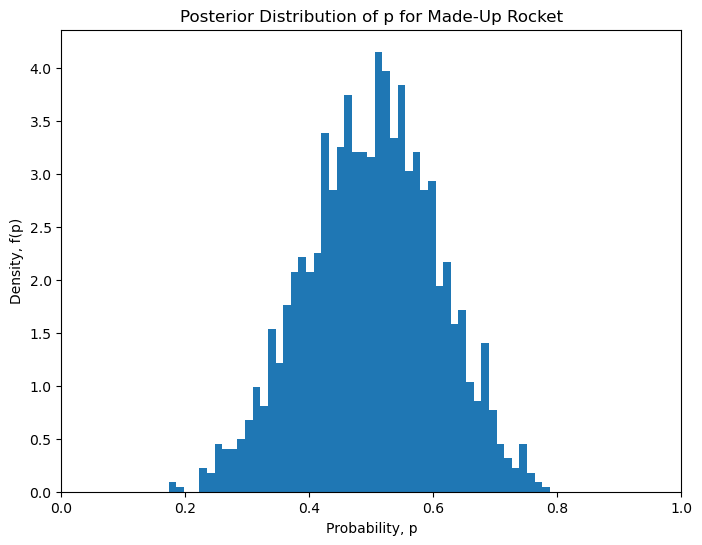

In [37]:
plt.figure(figsize=(8, 6))
plt.hist(posterior_rockets["p"], density=True, bins=50)
plt.title("Posterior Distribution of p for Made-Up Rocket")
plt.xlabel('Probability, p')
plt.ylabel('Density, f(p)')
plt.xlim(0, 1)
plt.show();

### Q1.2: Sample from the Posterior Distribution of $p$ for `Zenit-3SL`

In [25]:
Zenit_3SL_observed_data = rockets[rockets["LV.Type"] == 'Zenit-3SL']
Zenit_3SL_observed_data

,LV.Type,numberOfLaunches,numberOfFailures
364,Zenit-3SL,36,3


In [31]:
data_Zenit_3SL = {
    'n': Zenit_3SL_observed_data["numberOfLaunches"].values[0],
    'X': Zenit_3SL_observed_data["numberOfLaunches"].values[0] - Zenit_3SL_observed_data["numberOfFailures"].values[0],
    'a': 1,
    'b': 1
}

fit_Zenit_3SL = sm.sampling(data=data_Zenit_3SL, iter=10000, chains=1, warmup=1000, thin=5, seed=553)

In [32]:
fit_Zenit_3SL

Inference for Stan model: anon_model_2dfdc360ff21a08b0fd577cfd94fbfce.
1 chains, each with iter=10000; warmup=1000; thin=5; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p       0.9  1.2e-3   0.05   0.79   0.87    0.9   0.93   0.97   1620    1.0
lp__ -13.29    0.02    0.7  -15.2 -13.45 -13.02 -12.84 -12.79   1677    1.0

Samples were drawn using NUTS at Tue Sep 13 16:54:33 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [33]:
posterior_Zenit_3SL = pd.DataFrame({"p": fit_Zenit_3SL['p'], "lp__": fit_Zenit_3SL['lp__']})
posterior_Zenit_3SL

,p,lp__
0,0.939479,-13.341675
1,0.993049,-20.112824
2,0.871149,-12.886427
3,0.876490,-12.847953
4,0.950542,-13.751115
...,...,...
1795,0.876741,-12.846354
1796,0.861386,-12.977479
1797,0.773670,-14.667775
1798,0.814203,-13.720944


### Q1.3: Visualize from the Posterior Distribution of $p$ for Zenit-3SL using $\text{Beta}(a = 1, b = 1)$ Prior

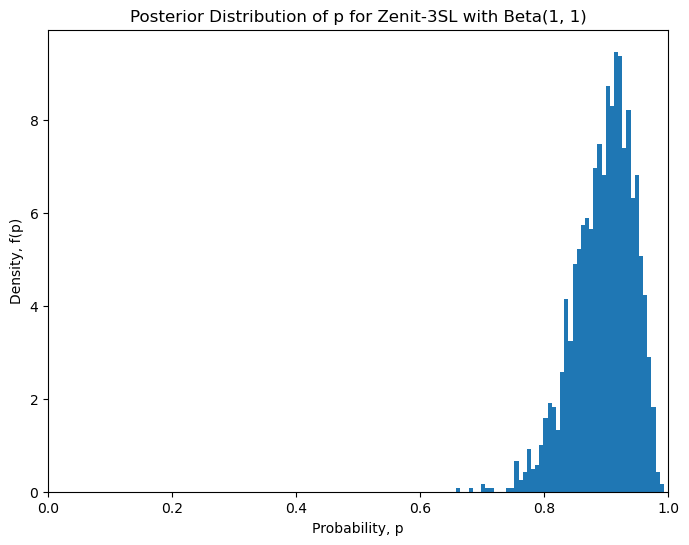

In [36]:
plt.figure(figsize=(8, 6))
plt.hist(posterior_Zenit_3SL["p"], density=True, bins=50)
plt.title("Posterior Distribution of p for Zenit-3SL with Beta(1, 1)")
plt.xlabel('Probability, p')
plt.ylabel('Density, f(p)')
plt.xlim(0, 1)
plt.show();

### Q1.4: Summary Statistics for the Posterior Samples of Zenit-3SL using $\text{Beta}(a = 1, b = 1)$ Prior

In [39]:
np.mean(posterior_Zenit_3SL["p"])

0.8960425791271323

In [40]:
np.median(posterior_Zenit_3SL["p"])

0.9020735909165447

In [41]:
np.var(posterior_Zenit_3SL["p"])

0.002264274575818576

In [44]:
percentiles = (0.05, 0.95)
print(pystan.stansummary(fit=fit_Zenit_3SL, probs=percentiles))

Inference for Stan model: anon_model_2dfdc360ff21a08b0fd577cfd94fbfce.
1 chains, each with iter=10000; warmup=1000; thin=5; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

       mean se_mean     sd     5%    95%  n_eff   Rhat
p       0.9  1.2e-3   0.05   0.81   0.96   1620    1.0
lp__ -13.29    0.02    0.7  -14.7 -12.79   1677    1.0

Samples were drawn using NUTS at Tue Sep 13 16:54:33 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Exercise 2: Rocket Data (Revisited)

In [45]:
Zenit_3SL_observed_data

,LV.Type,numberOfLaunches,numberOfFailures
364,Zenit-3SL,36,3
